<a href="https://colab.research.google.com/github/AngelPn/Netflix-Data-Analysis/blob/main/netflix_data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix Data Mining Notebook
This notebook deals with data from a well-known content platform and production company, Netflix. The following questions will be answered:
1. Which type is superior, the movies or the series?
2. Has Netflix invested more in movies or series in recent years?
3. Which country has the most content?
4. What kind of content (genre) does each country have?
5. Plot graphs showing the actors with the most movies in
each country. Do the same for the series.
6. Plot a graph that gathers the number of
movies depending on the suggested age. Do the same for the series.
7. If a producer wanted to have a high audience, he thinks it would
be better to make his film at a time when it does not exist much
competition. Plot a graph with the content added per month
to help him choose the right time period.
8. Prepare a chart that summarizes the types of content.
9. Plot graphs showing the directors in each country.
10. Plot graphs showing movies analog to number of seasons.
11. Which are the highest rated movies?


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [2]:
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
# For random selection 
import random
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# Machine learning libary
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

import datetime
import scipy.sparse as sp
import spacy

# Load Dataset
Read the data using pandas read_csv method and control missing data.

In [3]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/netflix_titles.csv'

df = pd.read_csv(Location)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s2  ...  After a devastating earthquake hits Mexico Cit...
2      s3  ...  When an army recruit is found dead, his fellow...
3      s4  ...  In a postapocalyptic world, rag-doll robots hi...
4      s5  ...  A brilliant group of students become card-coun...

[5 rows x 12 columns]

We are going to tackle each question step by step and only in case of need we will dismiss NA objects, in order not to exclude a sizeable portion of the data set.

# Question 1
Which type is superior, the movies or the series?

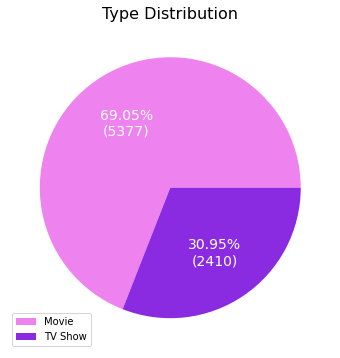

In [ ]:
types = df.groupby('type').size()

types.plot.pie(figsize = (6, 6),
               colors = ['violet', 'blueviolet'],
               textprops = {'fontsize': 14, 'color': 'w'},
               autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*types.sum()))
plt.title('Type Distribution', fontsize = 16)
plt.axis('off')
plt.legend()
plt.show()

Τhe most common type is 'Movie'.

# Question 2
Has Netflix invested more in movies or series in recent years?

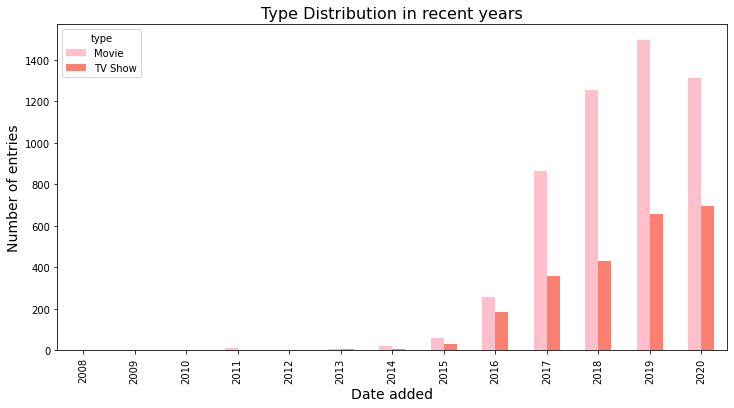

In [ ]:
# Make a list of all years from start_year to current_year (this year)
start_year = 1976
current_year = datetime.datetime.now().year
years = [str(year) for year in range(start_year, current_year)]

# Define pat: regular expression pattern with capturing groups
pat = '|'.join(years) 
# For each subject string in the Series, extract groups from the first match of regular expression pat.
year_added = df['date_added'].str.extract('('+ pat + ')', expand = False)
# Group by year added and type
df_group = df.groupby([year_added, 'type']).size()

df_group.unstack().plot.bar(figsize = (12, 6), color = ['pink', 'salmon'])
plt.title('Type Distribution in recent years', fontsize = 16)
plt.xlabel('Date added', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

In recent years, Netflix has invested more in movies.

# Question 3
Which country has the most content (movies or series)?

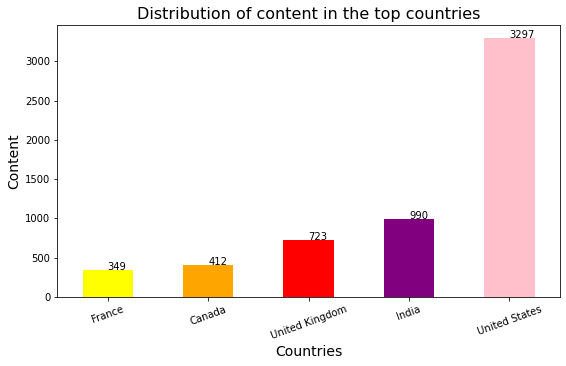

In [ ]:
# Use filter to dismiss NA values from country column
df_fltr = df[~df.country.isna()]

# Explode by country
df_new = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)

content = df_new.groupby(by = 'country')['show_id'].count().sort_values().tail(5)

content.plot.bar(color = ['yellow', 'orange', 'red', 'purple', 'pink'], figsize = (9, 5), rot = 0)
for index, value in enumerate(list(content)):
    plt.text(index, value, str(value))
plt.title('Distribution of content in the top countries', fontsize = 16)
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Countries', fontsize = 14)
plt.ylabel('Content', fontsize = 14)
plt.show()

United States has the most content with 3297 movies or TV shows.

# Question 4
What kind of content (genre) does each country have?

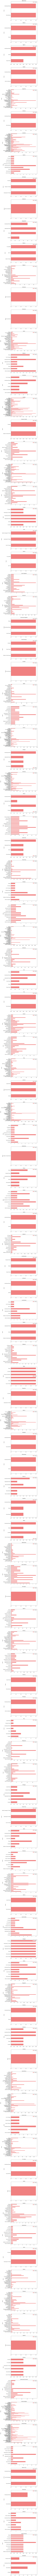

In [ ]:
# Use filter to dismiss NA values from country and listed_in columns
df_fltr = df[~df.country.isna() & (~df.listed_in.isna())]

# Explode by country and listed_in
df_new = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
df_new = df_new.assign(listed_in = df_new['listed_in'].str.strip().str.split(', ')).explode('listed_in').reset_index(drop = True)

# Group new dataframe by country and listed_in
df_group = df_new.groupby(['listed_in','country']).size().unstack()

cols = df_group.columns
fig, axes = plt.subplots(nrows = len(cols), ncols = 1, figsize = (8, 800))

# For each of the countries, plot a dataframe showing the distribution of genre in country
for idx, country in enumerate(cols):  
  res = df_group[country].reset_index([0, 'listed_in'])
  res.columns = ['Genre', 'Entries']
  res = res[~res['Entries'].isna()] # keep only the entries of genre that have values
  res.plot.barh(x = 'Genre', ax = axes[idx], color = ['lightcoral'], title = country)

plt.show()


# Question 5
Plot graphs showing the actors with the most movies in each country. Do the same for the series.

In [ ]:
# Use filter to dismiss NA values from country and cast columns
df_fltr = df[~df.country.isna() & ~df.cast.isna()]

# Explode by country and cast
new_df = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
new_df = new_df.assign(cast = new_df['cast'].str.strip().str.split(', ')).explode('cast').reset_index(drop = True)
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67592 entries, 0 to 67591
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       67592 non-null  object
 1   type          67592 non-null  object
 2   title         67592 non-null  object
 3   director      49523 non-null  object
 4   cast          67592 non-null  object
 5   country       67592 non-null  object
 6   date_added    67524 non-null  object
 7   release_year  67592 non-null  int64 
 8   rating        67553 non-null  object
 9   duration      67592 non-null  object
 10  listed_in     67592 non-null  object
 11  description   67592 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.2+ MB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s1  ...  In a future where the elite inhabit an island ...
2      s1  ...  In a future where the elite inhabit an island ...
3      s1  ...  In a future where the elite inhabit an island ...
4      s1  ...  In a future where the elite inhabit an island ...

[5 rows x 12 columns]

## For movies
Τhe actors with the most movies in each country.

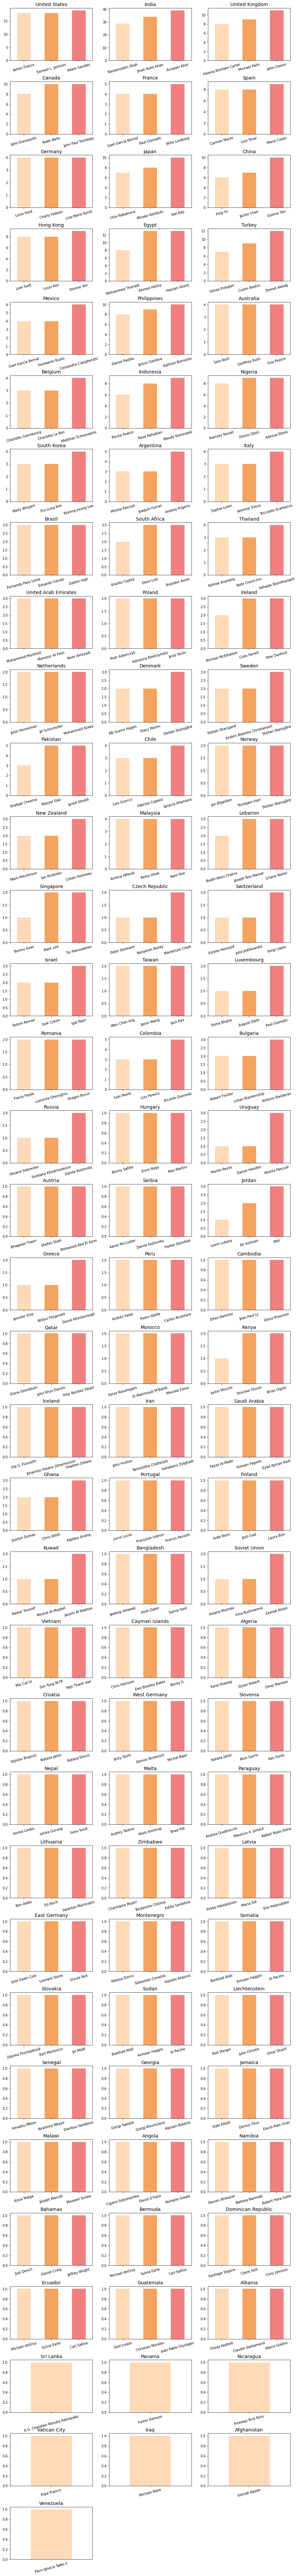

In [ ]:
countries_with_movies = new_df[new_df['type'] == 'Movie']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 140))

for idx, country in enumerate(countries_with_movies):
  ax = fig.add_subplot(35, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'Movie')]['cast'].value_counts().sort_values().tail(3)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

## For series
The actors with the most series in each country.

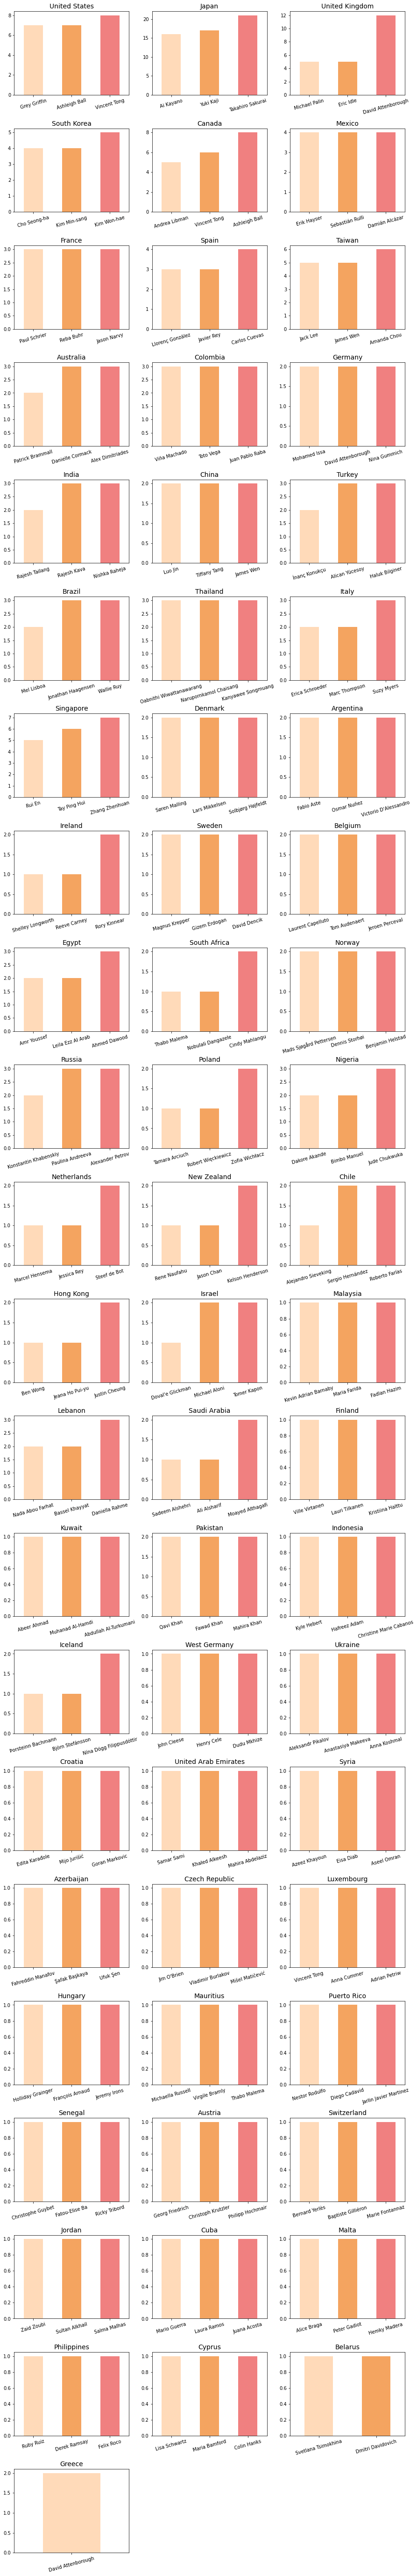

In [ ]:
countries_with_series = new_df[new_df['type'] == 'TV Show']['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 100))

for idx, country in enumerate(countries_with_series):
  ax = fig.add_subplot(22, 3, idx+1)
  result = new_df.loc[(new_df['country'] == country) & (new_df['type'] == 'TV Show')]['cast'].value_counts().sort_values().tail(3)
  result.plot.bar(color = ['peachpuff', 'sandybrown', 'lightcoral'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(hspace = 0.4)
plt.show()

# Question 6
Plot a graph that gathers the number of movies depending on the suggested age. Do the same for the series.

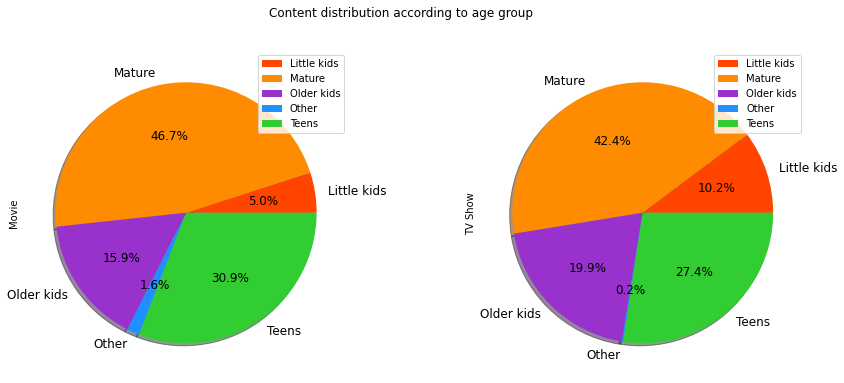

In [ ]:
little_kids = ['G', 'TV-Y', 'TV-G']
older_kids = ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
teens = ['PG-13', 'TV-14']
mature = ['R', 'NC-17', 'TV-MA']
rating_list = [little_kids, older_kids, teens, mature]
rating_names = ['Little kids', 'Older kids', 'Teens', 'Mature']

# Use filter to dismiss NA values from rating column
df_fltr = df[~df['rating'].isna()]
# Return an array drawn from elements in choicelist (rating_names), depending on conditions.
age_group = np.select([df_fltr['rating'].isin(categ) for categ in rating_list],
                      rating_names,
                      'Other')
# Group by age group and type
df_group = df_fltr.groupby([age_group,'type']).size().unstack(fill_value = 0)

df_group.plot.pie(subplots = True, 
                  figsize = (15, 6), 
                  shadow = True, 
                  legend = True, 
                  autopct = '%1.1f%%',
                  textprops = {'fontsize':12},
                  colors = ['orangered', 'darkorange', 'darkorchid', 'dodgerblue', 'limegreen'],
                  title = "Content distribution according to age group")

plt.show()

Based on the graphs, Netflix does not provide rich content for all ages, because of the small percentage of content for Little kids and Older kids, both for Movie and TV Show type of content.

# Question 7
If a producer wanted to have a high audience, he thinks it would be better to make his film at a time when it does not exist much competition. Plot a graph with the content added per month to help him choose the right time period.

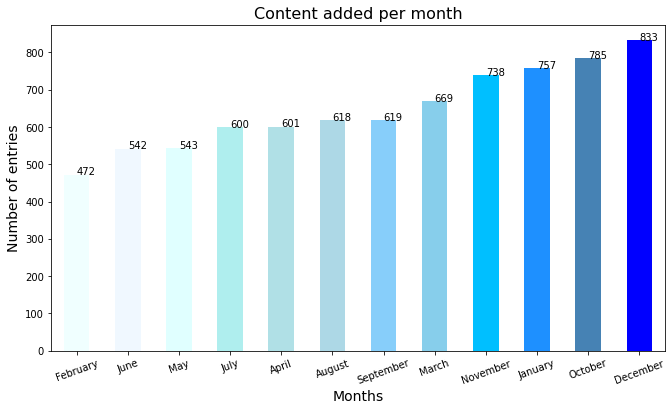

In [ ]:
# Use filter to dismiss NA values from date_added column
df_fltr = df[~df.date_added.isna()]

# Create a new dataframe from the series with show_id as the index extracting months
df_new = pd.DataFrame(df_fltr.date_added.str.strip().str.partition(" ")[0].tolist(), index = df_fltr.show_id).stack()
df_new = df_new.reset_index([0, 'show_id'])
df_new.columns = ['show_id', 'month']

# Group by month and count entries
df_group = df_new.groupby('month')['show_id'].count().sort_values()

df_group.plot.bar(figsize = (11, 6), 
                  rot = 0, 
                  color = ['azure', 'aliceblue', 'lightcyan', 'paleturquoise', 'powderblue', 'lightblue', 
                          'lightskyblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'steelblue', 'blue'])
for index, value in enumerate(list(df_group)):
    plt.text(index, value, str(value))
plt.title('Content added per month', fontsize = 16)
plt.xticks(rotation = 20, horizontalalignment="center")
plt.xlabel('Months', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()


According to plot graph, the producer should make his film in February.

# Question 8
Prepare a chart that summarizes the types of content (listed_in column).

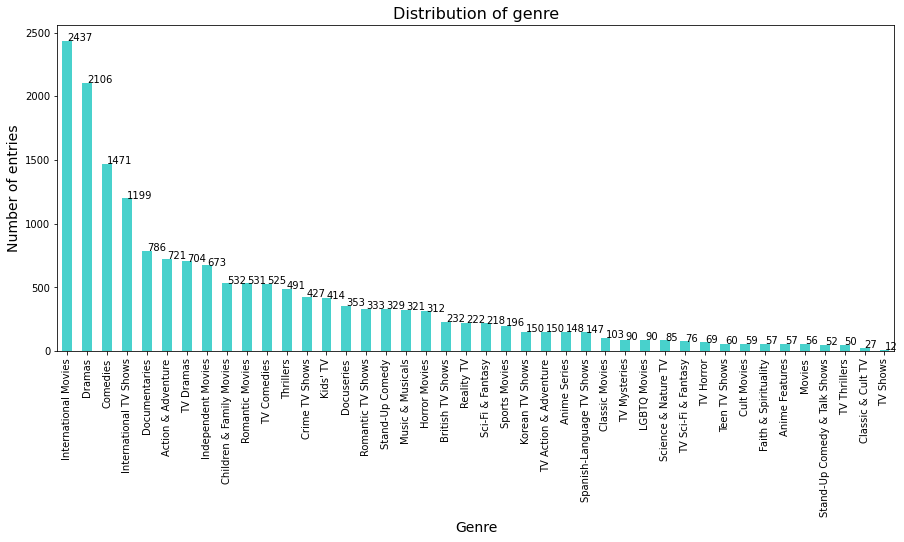

In [ ]:
# Use filter to dismiss NA values from listed_in column
df_fltr = df[~df['listed_in'].isna()]

# Explode by kind of content (listed_in columns)
df_new = df_fltr.assign(listed_in = df_fltr['listed_in'].str.strip().str.split(', ')).explode('listed_in').reset_index(drop = True)

# Group by listed_in column and count number of entries
df_new = df_new.groupby('listed_in').size().sort_values(ascending = False)
df_new.plot.bar(figsize = (15, 6), color = 'mediumturquoise')
for index, value in enumerate(list(df_new)):
    plt.text(index, value, str(value))
plt.title('Distribution of genre', fontsize = 16)
plt.xlabel('Genre', fontsize = 14)
plt.ylabel('Number of entries', fontsize = 14)
plt.show()

# Question 9
Plot graphs showing the directors in each country.

In [ ]:
# Use filter to dismiss NA values from country and director columns
df_fltr = df[~df.country.isna() & ~df.director.isna()]

# Explode by country and director
new_df = df_fltr.assign(country = df_fltr['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop = True)
new_df = new_df.assign(director = new_df['director'].str.strip().str.split(', ')).explode('director').reset_index(drop = True)

new_df.info()
new_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7590 non-null   object
 1   type          7590 non-null   object
 2   title         7590 non-null   object
 3   director      7590 non-null   object
 4   cast          6928 non-null   object
 5   country       7590 non-null   object
 6   date_added    7590 non-null   object
 7   release_year  7590 non-null   int64 
 8   rating        7586 non-null   object
 9   duration      7590 non-null   object
 10  listed_in     7590 non-null   object
 11  description   7590 non-null   object
dtypes: int64(1), object(11)
memory usage: 711.7+ KB


show_id  ...                                        description
0      s2  ...  After a devastating earthquake hits Mexico Cit...
1      s3  ...  When an army recruit is found dead, his fellow...
2      s4  ...  In a postapocalyptic world, rag-doll robots hi...
3      s5  ...  A brilliant group of students become card-coun...
4      s6  ...  A genetics professor experiments with a treatm...

[5 rows x 12 columns]

## Top directors in each country

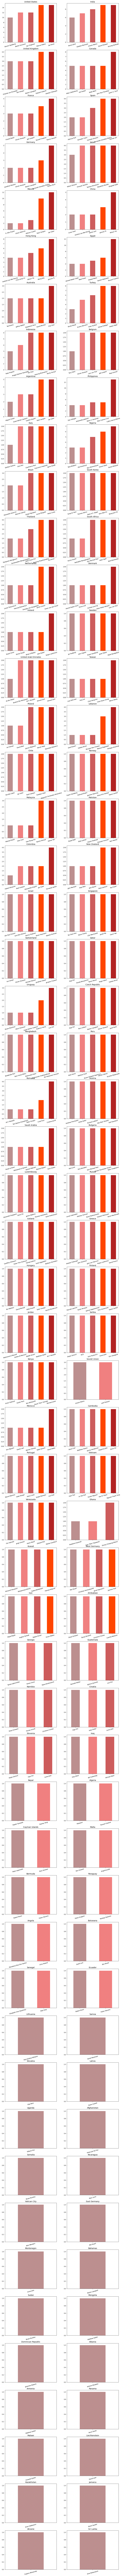

In [ ]:
countries_with_directors = new_df['country'].value_counts().keys().tolist()

fig = plt.figure(figsize = (15, 140))

for idx, country in enumerate(countries_with_directors):
  ax = fig.add_subplot(len(countries_with_directors)/2, 2, idx+1)
  result = new_df.loc[(new_df['country'] == country)]['director'].value_counts().sort_values().tail(5)
  result.plot.bar(color = ['rosybrown', 'lightcoral', 'indianred', 'orangered', 'firebrick'], rot = 0)
  ax.set_title(country, fontsize = 14)
  ax.tick_params('x', labelrotation = 15)

plt.subplots_adjust(top = 2.0)
plt.show()

## Number of directors in each country

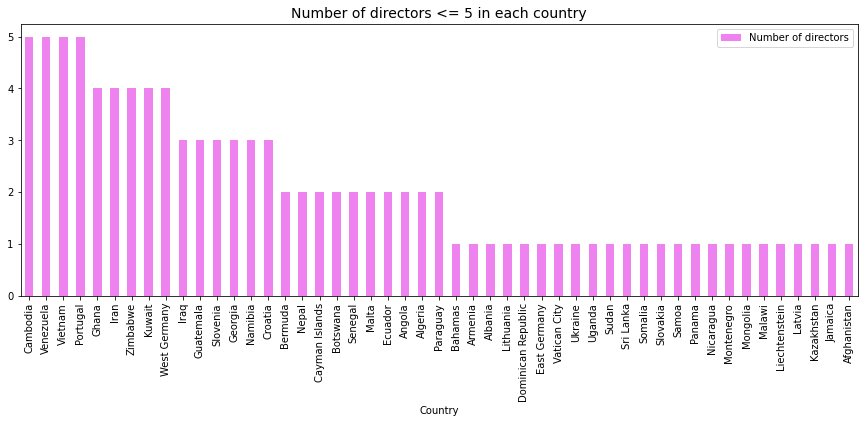

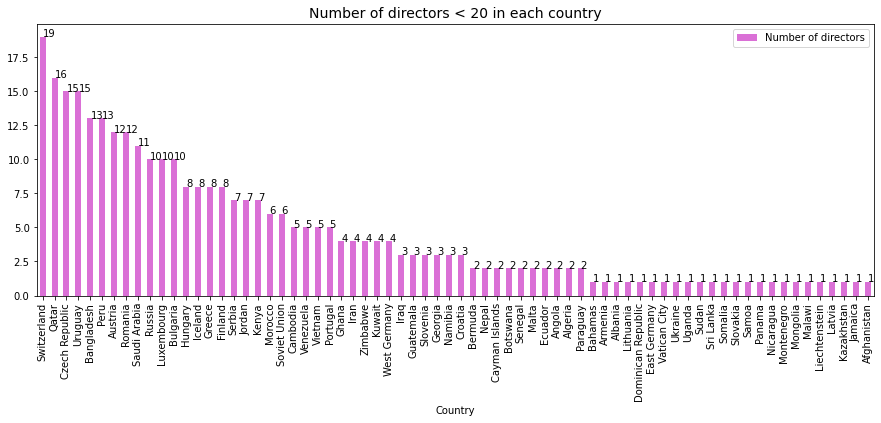

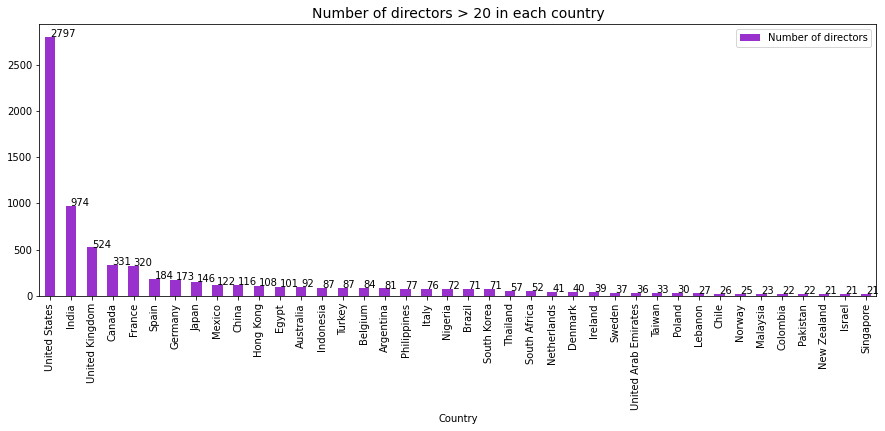

In [ ]:
# Get dataframe grouped by country and count directors
df_group = new_df.groupby(by = ['country'])['director'].count().sort_values(ascending = False)
df_group = df_group.reset_index([0, 'country'])
df_group.columns = ['Country', 'Number of directors']

df_group.loc[df_group['Number of directors'] <= 5].plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'violet')
plt.title('Number of directors <= 5 in each country', fontsize = 14)

df_group2 = df_group.loc[df_group['Number of directors'] <= 20]
df_group2.plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'orchid')
plt.title('Number of directors < 20 in each country', fontsize = 14)
for index, value in enumerate(list(df_group2['Number of directors'])):
    plt.text(index, value, str(value))

df_group3 = df_group.loc[df_group['Number of directors'] > 20]
df_group3.plot.bar(x = 'Country', y = 'Number of directors', figsize = (15, 5), color = 'darkorchid')
plt.title('Number of directors > 20 in each country', fontsize = 14)
for index, value in enumerate(list(df_group3['Number of directors'])):
    plt.text(index, value, str(value))

plt.show()


# Question 10
Plot graphs showing TV shows analog to number of seasons.

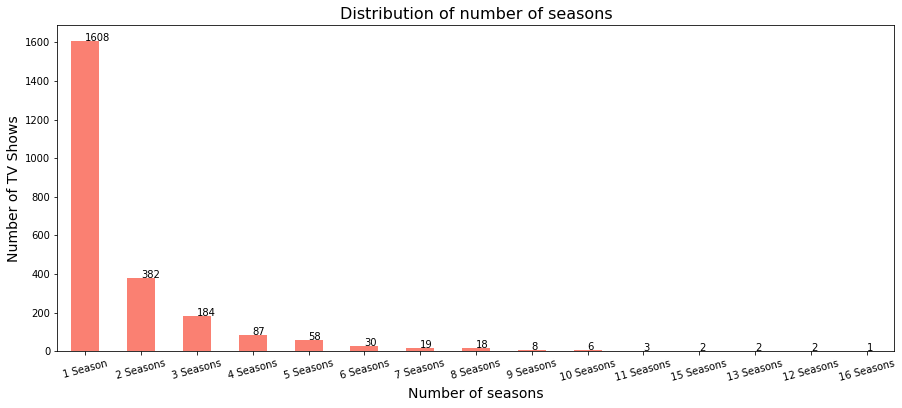

In [ ]:
# Use filter to dismiss NA values from duration column
df_new = df[~df.duration.isna()]
# Get dataframe only with TV shows
df_new = df_new[df_new['type'] == 'TV Show']

# Group by duration and count the number of TV shows
df_group = df_new.groupby('duration').size().sort_values(ascending = False)
df_group.plot.bar(figsize = (15, 6), color = 'salmon')
for index, value in enumerate(list(df_group)):
    plt.text(index, value, str(value))
plt.xticks(rotation = 15)
plt.title('Distribution of number of seasons', fontsize = 16)
plt.xlabel('Number of seasons', fontsize = 14)
plt.ylabel('Number of TV Shows', fontsize = 14)
plt.show()

# Question 11
Which are the highest rated movies?

Load datasets imdb movies and imbd ratings

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb ratings.csv'
df_imdbratings = pd.read_csv(Location)
df_imdbratings.info()
df_imdbratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              85855 non-null  object 
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes_2                    85855 non-null  int

imdb_title_id  ...  non_us_voters_votes
0     tt0000009  ...                 70.0
1     tt0000574  ...                331.0
2     tt0001892  ...                123.0
3     tt0002101  ...                105.0
4     tt0002130  ...               1166.0

[5 rows x 49 columns]

In [ ]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/data/IMDb movies.csv'
df_imdbmovies = pd.read_csv(Location)
df_imdbmovies.info()
df_imdbmovies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64
 15  vo

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


imdb_title_id  ... reviews_from_critics
0     tt0000009  ...                  2.0
1     tt0000574  ...                  7.0
2     tt0001892  ...                  2.0
3     tt0002101  ...                  3.0
4     tt0002130  ...                 14.0

[5 rows x 22 columns]

Find top netflix movies based on IMDb average vote

In [ ]:
# Match netflix titles with imdb's title with same release year
df_match_titles = pd.merge(df_imdbmovies, df, 
                          left_on=['title', 'year'],
                          right_on=['title', 'release_year'],
                          how='inner', suffixes=('_imdb','_ntflx'))

# Match netflix titles with imdb's original title with same release year
df_match_originaltitles = pd.merge(df_imdbmovies, df, 
                          left_on=['original_title', 'year'],
                          right_on=['title', 'release_year'],
                          how='inner', suffixes=('_imdb','_ntflx'))

df_matchtitles = pd.merge(df_match_titles, df_match_originaltitles, 
                          on=['imdb_title_id'],
                          how='inner', suffixes=('_imdb','_ntflx'))

top_ratings = df_matchtitles[['title', 'avg_vote_imdb']].sort_values(by='avg_vote_imdb', ascending=False).head(20)
top_ratings


title  avg_vote_imdb
48            Pulp Fiction            8.9
44        Schindler's List            8.9
432              Inception            8.8
320  Oththa Seruppu Size 7            8.6
17                Gol Maal            8.6
105                Koshish            8.6
188           Black Friday            8.5
73      American History X            8.5
545       Django Unchained            8.4
28                   Sadma            8.4
27                  Masoom            8.4
381               3 Idiots            8.4
11           Chupke Chupke            8.3
15             Taxi Driver            8.3
93         American Beauty            8.3
326    The Blue Elephant 2            8.3
318             Article 15            8.2
46         Andaz Apna Apna            8.2
191        Rang De Basanti            8.2
494                  Udaan            8.2

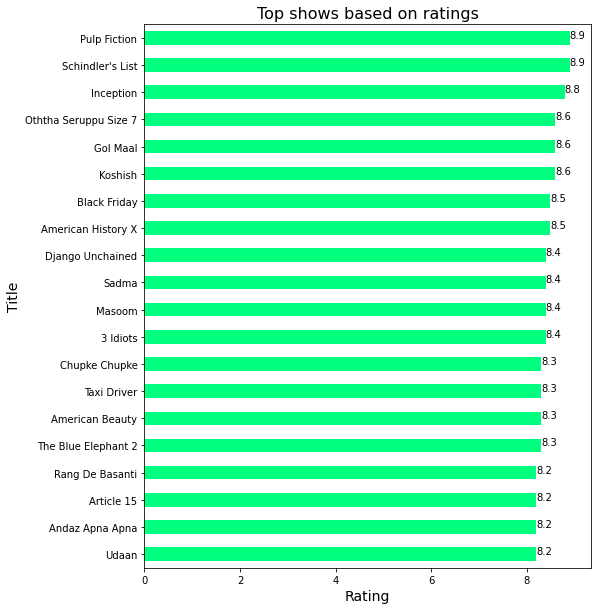

In [ ]:
# Plot top ratings
top_ratings = top_ratings.sort_values(by='avg_vote_imdb')
top_ratings.plot.barh(x = 'title', figsize = (8, 10), color = 'springgreen', legend=False)
for index, value in enumerate(list(top_ratings['avg_vote_imdb'])):
    plt.text(value, index, str(value))
plt.title('Top shows based on ratings', fontsize = 16)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Title', fontsize = 14)
plt.show()

# Recommendation system


In [16]:
# Create a new dataframe containing only the info show_id, title, description
df_sub = df[['show_id', 'title', 'description']]

df_sub.info()
df_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      7787 non-null   object
 1   title        7787 non-null   object
 2   description  7787 non-null   object
dtypes: object(3)
memory usage: 182.6+ KB


show_id  title                                        description
0      s1     3%  In a future where the elite inhabit an island ...
1      s2   7:19  After a devastating earthquake hits Mexico Cit...
2      s3  23:59  When an army recruit is found dead, his fellow...
3      s4      9  In a postapocalyptic world, rag-doll robots hi...
4      s5     21  A brilliant group of students become card-coun...

## Preprocessing
Τhe preprocessing is performed using the spaCy library of python as follows:
* Tokenization
* Lemmatization: using spaCy's built-in methods.
* Converting all the words to lower case
* Stopword Removal: using the "is_stop" attribute of the token object.
* Removing Punctuations: using "isalpha" method of string objects.

In [17]:
# Instantiate English module
nlp = spacy.load("en_core_web_sm")

lemmas = []
for i, row in df_sub.iterrows():
  # Create doc object from title and description
  doc = nlp(row['title']+' '+row['description'])
  # Filter our tokens
  lemmatized = [token.lemma_ for token in doc if (token.is_stop == False and token.text.isalpha() == True)]
  lemmas.append(' '.join(lemmatized))

df_sub.insert(len(df_sub.columns), 'lemmas', lemmas, True)
df_sub.head()


show_id  ...                                             lemmas
0      s1  ...  future elite inhabit island paradise far crowd...
1      s2  ...  devastating earthquake hit Mexico City trap su...
2      s3  ...  army recruit find dead fellow soldier force co...
3      s4  ...  postapocalyptic world rag doll robot hide fear...
4      s5  ...  brilliant group student card count expert inte...

[5 rows x 4 columns]

## Boolean Bag-of-Words

In [26]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, stop_words='english', binary=True)

bow_representation = bow_vectorizer.fit_transform(df_sub.lemmas)
print(bow_vectorizer.get_feature_names())
print(bow_representation.shape)


['aa', 'aa woman', 'aadha', 'aadha old', 'aadu', 'aadu shaji', 'aagey', 'aagey jeet', 'aagey se', 'aahe', 'aahe thanks', 'aaj', 'aaj kal', 'aajcha', 'aajcha divas', 'aakhri', 'aakhri adaalat', 'aaliya', 'aaliya experience', 'aalorukkam', 'aalorukkam age', 'aamir', 'aamir high', 'aamir khan', 'aana', 'aana futile', 'aane', 'aane ki', 'aang', 'aang long', 'aankh', 'aankh micholi', 'aap', 'aap sa', 'aapke', 'aapke hain', 'aapke paas', 'aapla', 'aapla manus', 'aarah', 'aarah sexually', 'aarakshan', 'aarakshan decision', 'aarambh', 'aarambh wedding', 'aardman', 'aardman aardman', 'aardman animations', 'aaron', 'aaron escort', 'aaron hatch', 'aaron hernandez', 'aaron paul', 'aashayein', 'aashayein learn', 'aashik', 'aashik awara', 'aata', 'aata hai', 'aata pita', 'aaviri', 'aaviri lose', 'aayiram', 'aayiram pon', 'abad', 'abad colorado', 'abagnale', 'abagnale bar', 'abah', 'abah emak', 'abandon', 'abandon beloved', 'abandon city', 'abandon competitive', 'abandon cub', 'abandon dream', 'aband

## Term Frequency - Inverse Document Frequency

In [19]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, stop_words='english')

tfidf_representation = tfidf_vectorizer.fit_transform(df_sub.lemmas)
print(tfidf_vectorizer.get_feature_names())
print(tfidf_representation.shape)



['aa', 'aa woman', 'aadha', 'aadha old', 'aadu', 'aadu shaji', 'aagey', 'aagey jeet', 'aagey se', 'aahe', 'aahe thanks', 'aaj', 'aaj kal', 'aajcha', 'aajcha divas', 'aakhri', 'aakhri adaalat', 'aaliya', 'aaliya experience', 'aalorukkam', 'aalorukkam age', 'aamir', 'aamir high', 'aamir khan', 'aana', 'aana futile', 'aane', 'aane ki', 'aang', 'aang long', 'aankh', 'aankh micholi', 'aap', 'aap sa', 'aapke', 'aapke hain', 'aapke paas', 'aapla', 'aapla manus', 'aarah', 'aarah sexually', 'aarakshan', 'aarakshan decision', 'aarambh', 'aarambh wedding', 'aardman', 'aardman aardman', 'aardman animations', 'aaron', 'aaron escort', 'aaron hatch', 'aaron hernandez', 'aaron paul', 'aashayein', 'aashayein learn', 'aashik', 'aashik awara', 'aata', 'aata hai', 'aata pita', 'aaviri', 'aaviri lose', 'aayiram', 'aayiram pon', 'abad', 'abad colorado', 'abagnale', 'abagnale bar', 'abah', 'abah emak', 'abandon', 'abandon beloved', 'abandon city', 'abandon competitive', 'abandon cub', 'abandon dream', 'aband

## Similar movies

### Jaccard/Tanimoto coefficiency for BoW

In [20]:
# Jaccard similarity function
def jaccard_similarity(matrix, row=None):
  mat = sp.csr_matrix(matrix.T, dtype='float')
  cols_sum = mat.getnnz(axis=0) # get number of columns
  if (row == None):
    ab = mat.T * mat
  else:
    ab = row * mat

  # for rows
  aa = np.repeat(cols_sum, ab.getnnz(axis=0))
  # for columns
  bb = cols_sum[ab.indices]

  similarities = ab.copy()
  similarities.data /= (aa + bb - ab.data)

  return similarities.T.toarray()

# Use of jaccard_similarity func to return an array containing the jaccard similarities of the rows of array. 
# The value in the i-th row and j-th column of the result is the cosine similarity between the i-th and j-th row of array.
jaccard_similarities = jaccard_similarity(bow_representation)

print(jaccard_similarities)


[[1.         0.         0.02040816 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.03333333 0.         0.        ]
 [0.02040816 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.03333333 0.         ... 1.         0.         0.03076923]
 [0.         0.         0.         ... 0.         1.         0.01639344]
 [0.         0.         0.         ... 0.03076923 0.01639344 1.        ]]


### Cosine similarity for TF-IDF

In [21]:
# Use of cosine_similarity to return an array containing the cosine similarities of the rows of array. 
# The value in the i-th row and j-th column of the result is the cosine similarity between the i-th and j-th row of array.
cosine_similarities = cosine_similarity(tfidf_representation)

print(cosine_similarities)

[[1.         0.         0.02140275 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.02620345 0.         0.        ]
 [0.02140275 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.02620345 0.         ... 1.         0.         0.02885833]
 [0.         0.         0.         ... 0.         1.         0.01047827]
 [0.         0.         0.         ... 0.02885833 0.01047827 1.        ]]


For each method, get the N indices with the maximum similarities.

In [22]:

def topN_val_indices(similarities, N = 100):
  # Fill diagonal with zeros in order to not recommend the same movie
  np.fill_diagonal(similarities, 0.0)

  #Initialize numpy array
  top_val_indices = np.zeros(shape = (len(similarities), N))
  # Get indices of N maximum values
  for i, x in enumerate(similarities):
    idx = np.argpartition(x, -N)[-N:]
    indices = idx[np.argsort((-x)[idx])]
    top_val_indices[i] = indices
  return top_val_indices


bowN_val_indices = topN_val_indices(jaccard_similarities)
tfidfN_val_indices = topN_val_indices(cosine_similarities)

print(bowN_val_indices)
print('\n')
print(tfidfN_val_indices)

[[5589.  575. 4235. ... 6511. 5114.   46.]
 [2564. 3537. 6269. ... 2685. 5170. 3923.]
 [1190. 4869. 7312. ... 5988. 6653. 6817.]
 ...
 [5038. 1705. 5706. ... 4772. 2793. 3332.]
 [3004. 1279. 6087. ... 6762. 3920. 2195.]
 [3378. 3713. 3332. ... 7231. 1635. 7201.]]


[[3069. 2172. 2045. ... 7195. 7619. 2872.]
 [2564. 6269. 7390. ...  862. 7458. 6779.]
 [1190. 6283. 7312. ... 2997. 2651. 3089.]
 ...
 [2281. 5038. 5536. ... 5474.  544. 6326.]
 [7628. 1279. 4387. ... 5969. 5915. 4980.]
 [5242. 5585. 5103. ... 4054. 4642. 6016.]]


For each movie, find the top 100 similar movies and store this information to a dictionary.

In [23]:
# Dictionaries with key a movie title and value a list with the top N similar movies
bow_similars = {}
tfidf_similars = {}

for i, row in df_sub.iterrows():

  bow_similars[row['title']] = []
  tfidf_similars[row['title']] = []

  for j in bowN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    bow_similars[row['title']].append(similar_movie)

  for j in tfidfN_val_indices[i]:
    similar_movie = df_sub.iloc[int(j)]['title']
    tfidf_similars[row['title']].append(similar_movie)


## Reccomendation

### Get similar movies depending on a title

In [24]:
def get_similar_movies1(title, N, method = 'boolean'):
  if method == 'boolean':
    if title in bow_similars:
      print("Suggested movies for '" + title + "' with 'boolean' method:")
      for i in range(N):
        print(str(i + 1) + '. ' + bow_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  elif method == 'tf-idf':
    if title in tfidf_similars:
      print("Suggested movies for '" + title + "' with 'tf-idf' method:")
      for i in range(N):
        print(str(i + 1) + '. ' + tfidf_similars[title][i])
    else:
      print("Movie doesn't exist. Choose different movie")
  else:
    print("Invalid method. Choose tf-idf or boolean.")


get_similar_movies1('American Beauty', 10)
print("\n")
get_similar_movies1('American Beauty', 10, 'tf-idf')
print("\n")

get_similar_movies1('Inception', 10)
print("\n")
get_similar_movies1('Inception', 10, 'tf-idf')
print("\n")

desc1 = df_sub[df_sub['title'] == 'Inception']
print(desc1.iloc[0]['description'])
print((df_sub[df_sub['title'] == 'Apollo 18'].iloc[0]['description']))
print("\n")

get_similar_movies1('You', 10, method='boolean')
print("\n")
get_similar_movies1('You', 10, method='tf-idf')
print("\n")


Suggested movies for 'American Beauty' with 'boolean' method:
1. A Chaster Marriage
2. Brown Nation
3. Santo Cachón
4. Drunk Parents
5. Never Have I Ever
6. The Twelve
7. Echcharikkai
8. Going for Gold
9. Fractured
10. R.K.Nagar


Suggested movies for 'American Beauty' with 'tf-idf' method:
1. A Chaster Marriage
2. Rainbow Time
3. Thottappan
4. Drunk Parents
5. Go Karts
6. Beauty and the Bitches
7. The Titan
8. The Boy Who Harnessed the Wind
9. Victim of Beauty
10. Brown Nation


Suggested movies for 'Inception' with 'boolean' method:
1. Apollo 18
2. Til Death Do Us Part
3. Candyflip
4. Backfire
5. Dark
6. Transformers: Cyberverse
7. Maniac
8. Abby Sen
9. Altered Carbon
10. Forbidden Planet


Suggested movies for 'Inception' with 'tf-idf' method:
1. Apollo 18
2. Til Death Do Us Part
3. Transformers: Cyberverse
4. Abby Sen
5. Black Mirror
6. Candyflip
7. Dark
8. Altered Carbon
9. Maniac
10. Forbidden Planet


In this mind-bending sci-fi thriller, a man runs an espionage business built a

As shown by the results, some of the recommended movies or series are same for both boolean and tf-idf methods. For instance, as for the movie 'Inception', there is only one different movie title out of ten between these two methods. As for the movie 'American Beauty', there are six different recommended movie titles out of ten. Tf-idf method seems to stick more to keywords in title, because there are suggested two movie titles with keyword "beauty", without having anything to do with the initial movie.

### Get similar movies depending on a text

In [ ]:
def get_similar_movies2(text, N = 10, method = 'boolean'):
  #lemmatize
  doc = nlp(text)
  lemmatized = [token.lemma_ for token in doc if not token.is_stop == True]
  lemmatized_string = ' '.join(lemmatized)

  sim = [] # list of similars 
  if method == 'boolean':
    bow_vectorizer.fit(df_sub.lemmas)
    new_bow_representation = bow_vectorizer.transform([lemmatized_string])
    sim = jaccard_similarity(new_bow_representation, bow_representation)
  elif method == 'tf-idf':
    tfidf_vectorizer.fit(df_sub.lemmas)
    new_representation = tfidf_vectorizer.transform([lemmatized_string])
    sim = cosine_similarity(new_representation, tfidf_representation)
  else:
    print("Invalid method. Choose tf-idf or boolean.")
  
  sim = sim.flatten()
  # print movies/series that match
  # get top matches' indices
  idx = np.argpartition(sim, -N)[-N:]
  indices = idx[np.argsort((-sim)[idx])]

  sims_list = []
  for j in indices: # match indices
    similar_movie = df_sub.iloc[int(j)]['title']
    sims_list.append(similar_movie)
  
  print('\nDescription given: '+ text+'\n')
  for item in sims_list:
    print(item+': '+df_sub[df_sub['title'] == item].iloc[0]['description'])

text = 'creepy guy stalks a girl in a bookstore'
get_similar_movies2(text, method='tf-idf')
get_similar_movies2(text, method='boolean')


Description given: creepy guy stalks a girl in a bookstore

You: Obsessed with an aspiring writer, a charming bookstore manager goes to extreme measures to insert himself into her life.
Stephanie: A menacing, unseen force stalks a young girl living by herself in a suburban house, where she's surrounded by reminders of her once-happy family.
A Good Wife: As her seemingly idyllic life begins to crumble, a lonely woman in a restrictive marriage starts an affair with a gentle bookstore owner.
The Bittersweet: As a killer stalks the streets, a troubled young courier suspects that a doctor may be the long-lost sister he hasn't seen since childhood.
Room for Rent: To save his parents’ home, a lottery-squandering 32-year-old man sublets a room to a disarmingly creepy tenant.
Two Fathers: When two single guys learn a woman they both slept with disappeared after giving birth, they decide to raise her baby girl together as a family.
The Occupant: An unemployed advertising executive begins stalki